# Emotion Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator #for understanding of image
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


**Exploring Dataset**

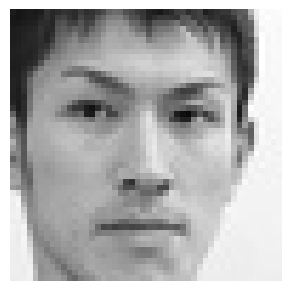

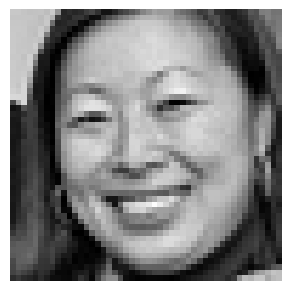

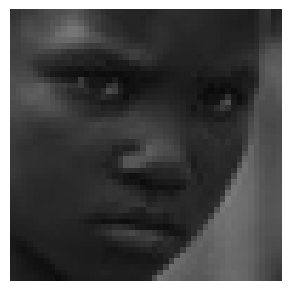

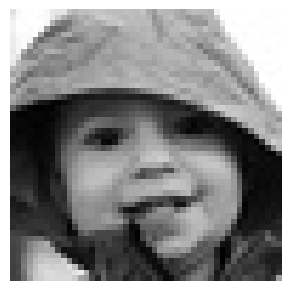

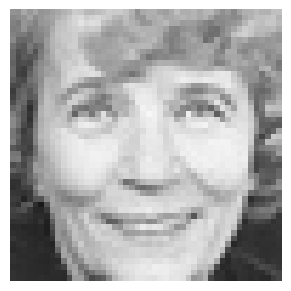

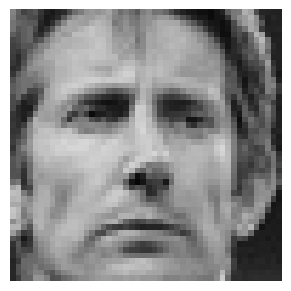

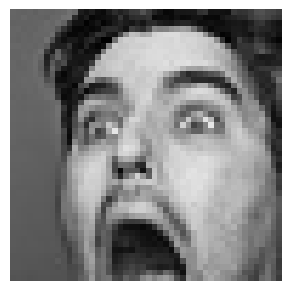

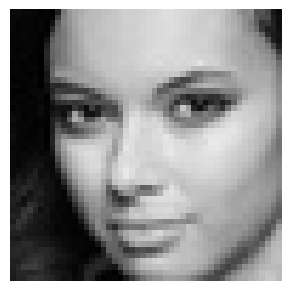

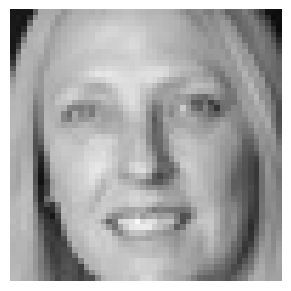

In [4]:
images = glob("C:/Users/Shuaib/Desktop/ML Internship/Emotion Detection/train/**/**")
for i in range(1,10):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(3,3,i)
    img = cv2.imread(image)
    plt.imshow(img)
    plt.axis("off")

**Preparing Data**

In [47]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(validation_split=0.25,
                                   horizontal_flip=True)
training_generator = datagen_train.flow_from_directory("C:/Users/Shuaib/Desktop/ML Internship/Emotion Detection/train/",
                                                      target_size = (img_size,img_size),
                                                      batch_size = batch_size,
                                                      color_mode = "grayscale",
                                                      class_mode = "categorical",
                                                      shuffle = True,
                                                      subset = "training")

validation_generator = datagen_train.flow_from_directory("C:/Users/Shuaib/Desktop/ML Internship/Emotion Detection/train/",
                                                        target_size = (img_size,img_size),
                                                        color_mode = "grayscale",
                                                        batch_size = batch_size,
                                                        class_mode = "categorical",
                                                        shuffle = True,
                                                        subset = "validation")

datagen_test = ImageDataGenerator()
testing_generator = datagen_test.flow_from_directory("C:/Users/Shuaib/Desktop/ML Internship/Emotion Detection/test/",
                                                        target_size = (img_size,img_size),
                                                        color_mode = "grayscale",
                                                        batch_size = batch_size,
                                                        class_mode = "categorical",
                                                        shuffle = True)

Found 21535 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [48]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x) #activation function
    x = MaxPooling2D(pool_size=(2,2))(x) #reduce dimensions
    x = Dropout(0.25)(x) #overcome overfitting
    return x


In [49]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [50]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))
    conv_3 = Convolution(conv_2, 512, (3,3))
    conv_4 = Convolution(conv_3, 512, (3,3))
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1,512)
    
    output = Dense(7, activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    opt = Adam(learning_rate=0.001)
    model.compile(loss = ["categorical_crossentropy"], optimizer = opt, metrics = ["accuracy"])
    
    return model

In [51]:
model = model_fer((48,48,1))
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_30 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_30 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 24, 24, 64)        0   

**Initializing the model**

In [52]:
epochs = 30
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_loss", save_weights_only = True, mode = "min", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

# Training the Model

In [53]:
history = model.fit(
x = training_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/30
336/336 [==============================] - ETA: 0s - loss: 1.8420 - accuracy: 0.2835
Epoch 1: saving model to model_weights.h5
336/336 [==============================] - 493s 1s/step - loss: 1.8420 - accuracy: 0.2835 - val_loss: 2.2107 - val_accuracy: 0.2633 - lr: 0.0010
Epoch 2/30
336/336 [==============================] - ETA: 0s - loss: 1.4855 - accuracy: 0.4288
Epoch 2: saving model to model_weights.h5
336/336 [==============================] - 479s 1s/step - loss: 1.4855 - accuracy: 0.4288 - val_loss: 2.0627 - val_accuracy: 0.3652 - lr: 0.0010
Epoch 3/30
336/336 [==============================] - ETA: 0s - loss: 1.3261 - accuracy: 0.4901
Epoch 3: saving model to model_weights.h5
336/336 [==============================] - 483s 1s/step - loss: 1.3261 - accuracy: 0.4901 - val_loss: 1.3990 - val_accuracy: 0.4717 - lr: 0.0010
Epoch 4/30
336/336 [==============================] - ETA: 0s - loss: 1.2362 - accuracy: 0.5299
Epoch 4: saving model to model_weights.h5
336/336 [====

Epoch 30/30
336/336 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.7427
Epoch 30: saving model to model_weights.h5
336/336 [==============================] - 480s 1s/step - loss: 0.6928 - accuracy: 0.7427 - val_loss: 1.0112 - val_accuracy: 0.6366 - lr: 1.0000e-05


**Model Evaluation**

In [57]:
model.evaluate(validation_generator)

113/113 [==============================] - 37s 329ms/step - loss: 1.0081 - accuracy: 0.6380


[1.0080569982528687, 0.6379983425140381]

**Plotting Loss**

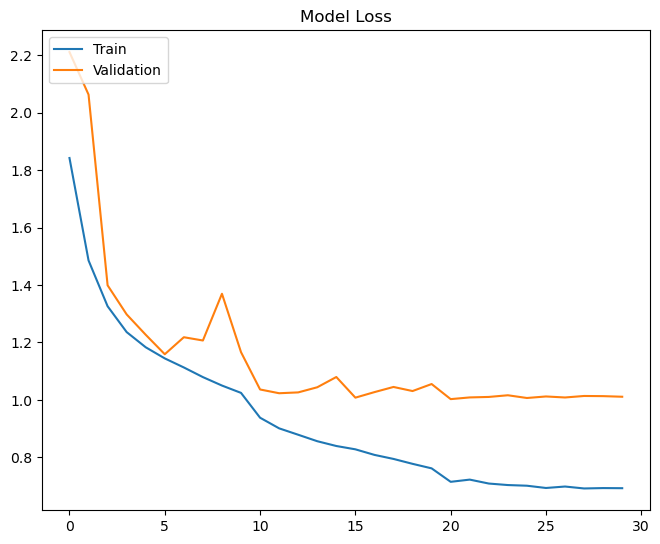

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

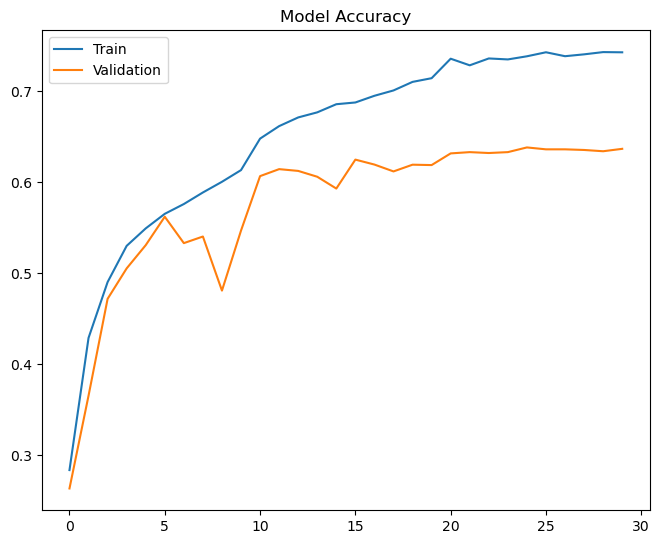

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Saving Model**

In [60]:
model_json = model.to_json()
with open('model_a.json',"w") as json_file:
    json_file.write(model_json)